<a href="https://www.kaggle.com/code/malekechaker/personlised-hermes-items?scriptVersionId=227261669" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Personlised Hermes items

## Setup

Let's start with importing TF2 and all relevant dependencies.

In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.9.2
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  []


Let's get as well some images to play with.

In [2]:
!pip install rembg

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-non

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


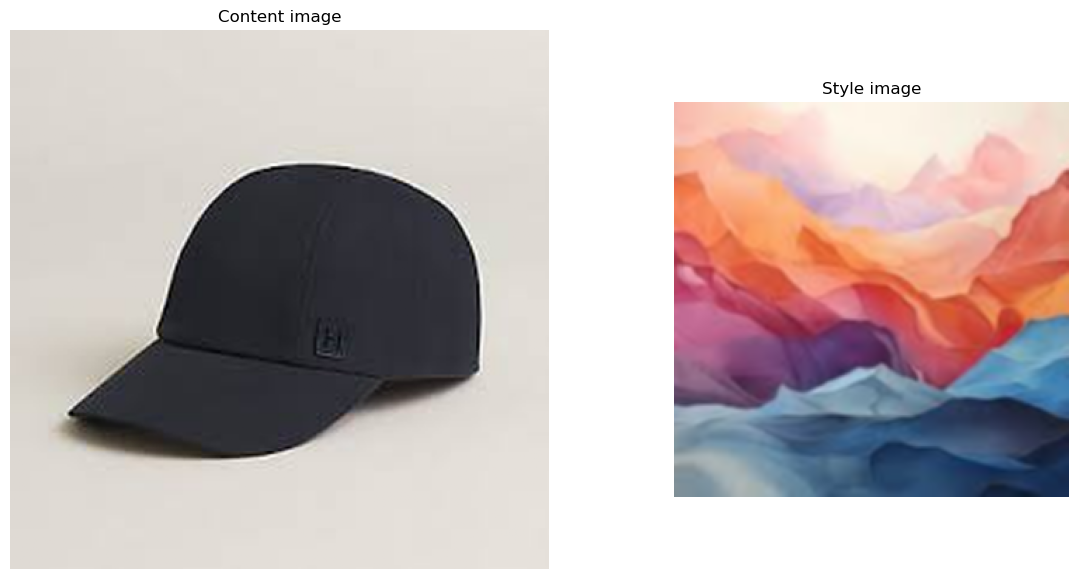

In [3]:
import functools
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import io
import cv2

def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])
    offset_y = max(shape[1] - shape[2], 0) // 2
    offset_x = max(shape[2] - shape[1], 0) // 2
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape)
    return image


def load_image_context(image_path, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images from a local Kaggle path without background removal."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize(image_size, Image.LANCZOS)
    img = np.array(img) / 255.0  # Normalize to range [0,1]
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def load_image(image_path, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images from a local Kaggle path."""
    img = tf.io.decode_image(
        tf.io.read_file(image_path),
        channels=3, dtype=tf.float32)[tf.newaxis, ...]
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

# Example local Kaggle paths
content_image_path = '/kaggle/input/hermesdataart/cap.jpg'  # Replace with actual local path
style_image_path = '/kaggle/input/hermesdataart/art3.jpg'  # Replace with actual local path

output_image_size = 384  # Define output size
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)  # Recommended to keep at 256

content_image = load_image_context(content_image_path, content_img_size)
style_image = load_image(style_image_path, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])


In [4]:
# Load TF Hub module.

hub_handle = '/kaggle/input/arbitrary-image-stylization-v1/tensorflow1/256/2'
hub_module = hub.load(hub_handle)
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]


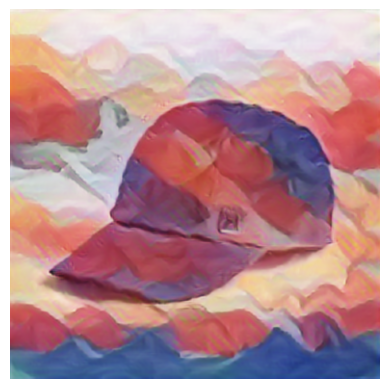

In [5]:
stylized_image = np.squeeze(stylized_image, axis=0)

plt.imshow(stylized_image)
plt.axis('off')  # Hide axes
plt.show()

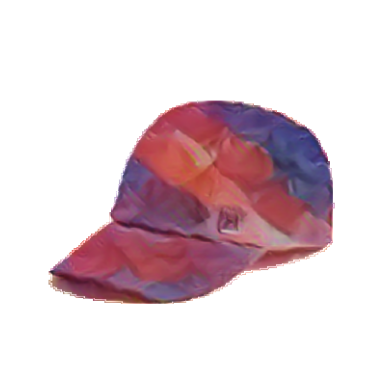

In [6]:
import cv2
import numpy as np
from PIL import Image

def get_object_mask(image_path):
    """Extracts a binary mask of the object from the content image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Adaptive Threshold for a more precise mask
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return mask

def get_background_from_content(content_image, mask):
    """Extracts the background from the content image by masking out the object."""
    mask_inv = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(content_image, content_image, mask=mask_inv)
    return background

def apply_background_mask(stylized_image, mask, content_background):
    """Applies the inverse of the mask to the stylized image and blends it with the original background."""
    stylized_image = np.array(stylized_image)
    
    # Ensure the mask is the same size as the stylized image
    mask = cv2.resize(mask, (stylized_image.shape[1], stylized_image.shape[0]))
    
    # Ensure the mask is single-channel (grayscale)
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Ensure the mask is of type CV_8U
    mask = mask.astype(np.uint8)
    
    # Inverse of the mask to target the background
    mask_inv = cv2.bitwise_not(mask)
    
    # Separate the stylized background using the inverse mask
    background = cv2.bitwise_and(stylized_image, stylized_image, mask=mask_inv)
    
    # Ensure the content_background is the same size as the stylized image
    content_background = cv2.resize(content_background, (stylized_image.shape[1], stylized_image.shape[0]))
    
    # Ensure the content_background is of type CV_8U
    content_background = content_background.astype(np.uint8)
    
    # Separate the original foreground using the mask
    foreground = cv2.bitwise_and(content_background, content_background, mask=mask)
    
    # Merge the stylized background and the original foreground
    final_image = cv2.add(foreground, background)
    
    return Image.fromarray(final_image)

# Example usage

# Convert stylized image to PIL format
stylized_image_pil = Image.fromarray((stylized_image * 255).astype(np.uint8))

# Extract the mask for the object
object_mask = get_object_mask(content_image_path)

# Read the content image
content_image = cv2.imread(content_image_path)

# Get the background of the content image
content_background = get_background_from_content(content_image, object_mask)

# Apply the background mask and blend with the stylized image
final_stylized_image = apply_background_mask(stylized_image_pil, object_mask, content_background)

final_image_np = np.array(final_stylized_image)

# Identifier les pixels noirs
black_pixels = np.all(final_image_np == [0, 0, 0], axis=-1)

# Remplacer les pixels noirs par du blanc
final_image_np[black_pixels] = [255, 255, 255]

# Convertir l'image modifiée en format PIL
final_stylized_image = Image.fromarray(final_image_np)

# Display the final stylized image
plt.imshow(final_stylized_image)
plt.axis('off')  # Hide axes
plt.show()

Credit: https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb